In [1]:
# 6-39 필요한 라이브러리 호출
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# 6-40 VGG 모델 정의
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d(1)  # 7 -> 1
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = torch.flatten(x, 1)   # 임베딩
        x = self.classifier(x)    # 이미 Flatten 포함
        return x, h

In [3]:
# 6-41 모델 유형 정의

# 합성곱층 8 + 풀링층 3 = 전체계층 11 = VGG11
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

# 합성곱층 10 + 풀링층 3 = 전체계층 13 = VGG13
vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

# 합성곱층 13 + 풀링층 3 = 전체계층 16 = VGG16
vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512,
                512, 'M']

# 합성곱층 16 + 풀링층 3 = 전체계층 19 = VGG19
vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M',
                512, 512, 512, 512, 'M']

In [4]:
# 6-42 VGG 계층 정의
def get_vgg_layers(config, batch_norm):
    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M': # 불러온 값이 M이면 최대풀링(MaxPool2d) 적용
            layers += [nn.MaxPool2d(kernel_size = 2)]
        else: # 불러온 값이 숫자이면 합성곱(Conv2d) 적용
            conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
            if batch_norm: # 배치 정규화(batch normalization)을 적용할지에 대한 코드
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)] # 배치 정규화가 적용될 경우 배치 정규화+ReLU 적용
            else:
                layers += [conv2d, nn.ReLU(inplace = True)] # 배치 정규화가 적용되지 않을 경우 ReLU만 적용
            in_channels = c

    return nn.Sequential(*layers) # 네트워크의 모든 계층을 반환

In [5]:
# 6-43 모델 계층 생성
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm = True)

In [6]:
# 6-44 VGG11 계층 확인
print(vgg11_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [7]:
# 6-45 VGG11 전체에 대한 네트워크
OUTPUT_DIM = 2 # 개와 고양이 두 개의 클래스 사용
model = VGG(vgg11_layers, OUTPUT_DIM)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [8]:
# 6-46 VGG11 사전 훈련된 모델 사용
import torchvision.models as models
pretrained_model = models.vgg11_bn(pretrained = True)
print(pretrained_model)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [9]:
# 6-47 이미지 데이터 전처리
train_transforms = transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [10]:
import zipfile
import os

# 압축 해제 경로를 코드와 맞춰주기 위해 폴더 생성
extract_path = "../chap06_1/data/catanddog"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile("catanddog.zip", 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("압축 해제 완료:", os.listdir(extract_path))

압축 해제 완료: ['train', 'test']


In [11]:
# 6-48 ImageFolder를 이용하여 데이터셋 불러오기
train_path = '../chap06_1/data/catanddog/train' # 훈련 데이터셋이 위치한 경로
test_path = '../chap06_1/data/catanddog/test' # 테스트 데이터셋이 위치한 경로

train_dataset = torchvision.datasets.ImageFolder(
    train_path,
    transform=train_transforms
)

test_dataset = torchvision.datasets.ImageFolder(
    test_path,
    transform=test_transforms
)

print(len(train_dataset)), print(len(test_dataset))

529
12


(None, None)

In [12]:
# 6-49 훈련과 검증 데이터 분할
VALID_RATIO = 0.9
n_train_examples = int(len(train_dataset) * VALID_RATIO)  # 전체 훈련 데이터 중 90%를 훈련 데이터셋으로 사용
n_valid_examples = len(train_dataset) - n_train_examples  # 전체 훈련 데이터 중 10%를 검증 데이터셋으로 사용

train_data, valid_data = data.random_split(train_dataset,
                                           [n_train_examples, n_valid_examples])

In [13]:
# 6-50 검증 데이터 전처리
alid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [14]:
# 6-51 훈련, 검증, 테스트 데이터셋 수 확인
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 476
Number of validation examples: 53
Number of testing examples: 12


In [15]:
# 6-52 메모리로 데이터 불러오기
BATCH_SIZE = 4
train_iterator = data.DataLoader(
    train_data, shuffle=True, batch_size=BATCH_SIZE,
    num_workers=0, pin_memory=True
)
valid_iterator = data.DataLoader(
    valid_data, batch_size=BATCH_SIZE,
    num_workers=0, pin_memory=True
)
test_iterator = data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE,
    num_workers=0, pin_memory=True
)

In [16]:
# 6-53 옵티마이저와 손실 함수 정의
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [17]:
# 6-54 모델 정확도 측정 함수
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [18]:
# 6-55 모델 학습 함수 정의
def train(model, iterator, optimizer, criterion, device, log_every=20):
    epoch_loss = 0.0
    epoch_acc = 0.0
    model.train()

    for step, (x, y) in enumerate(iterator, 1):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad(set_to_none=True)
        y_pred, _ = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

        # 진행 로그
        if step % log_every == 0:
            print(f'  step {step} | loss {loss.item():.4f} | acc {acc.item()*100:.2f}%')

        del x, y, y_pred, loss
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [19]:
# 6-56 모델 성능 측정 함수
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0.0
    epoch_acc = 0.0
    model.eval()
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            del x, y, y_pred, loss
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [20]:
# 6-57 학습 시간 측정 함수
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [21]:
# 6-58 모델 학습
import time, gc

EPOCHS = 1
best_valid_loss = float('inf')
for epoch in range(EPOCHS):
    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device, log_every=20)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '../chap06_1/data/VGG-model.pt')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'  Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'  Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')

    # 메모리 정리
    gc.collect()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  step 20 | loss 0.4789 | acc 75.00%
  step 40 | loss 0.6816 | acc 50.00%
  step 60 | loss 0.5771 | acc 75.00%
  step 80 | loss 0.6651 | acc 50.00%
  step 100 | loss 0.6007 | acc 50.00%
Epoch: 01 | Epoch Time: 9m 40s
  Train Loss: 0.706 | Train Acc: 53.78%
  Valid Loss: 0.670 | Valid Acc: 58.93%


In [22]:
# 6-59 테스트 데이터셋을 이용한 모델 성능 측정
model.load_state_dict(torch.load('../chap06_1/data/VGG-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.597 | Test Acc: 66.67%


In [23]:
# 6-60 테스트 데이터셋을 이용한 모델의 예측 확인 함수
def get_predictions(model, iterator):
    model.eval()
    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    return images, labels, probs

In [24]:
# 6-61 예측 중에서 정확하게 예측한 것을 추출
images, labels, probs = get_predictions(model, test_iterator)
pred_labels = torch.argmax(probs, 1)
corrects = torch.eq(labels, pred_labels)
correct_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if correct:
        correct_examples.append((image, label, prob))

correct_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [25]:
# 6-62 이미지 출력을 위한 전처리
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max) # torch.clamp는 주어진 최소, 최대의 범주에 이미지가 위치하도록 함
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [26]:
# 6-63 모델이 정확하게 예측한 이미지 출력 함수
def plot_most_correct(correct, classes, n_images, normalize = True):
    rows = int(np.sqrt(n_images)) # np.sqrt는 제곱근을 계산
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize = (25, 20))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)  # 출력하려는 그래프 개수만큼 subplot을 만듭니다
        image, true_label, probs = correct[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        correct_prob, correct_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        correct_class = classes[correct_label]

        if normalize: # 본래 이미지대로 출력하기 위해 normalize_image 함수 호출
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {correct_class} ({correct_prob:.3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace = 0.4)

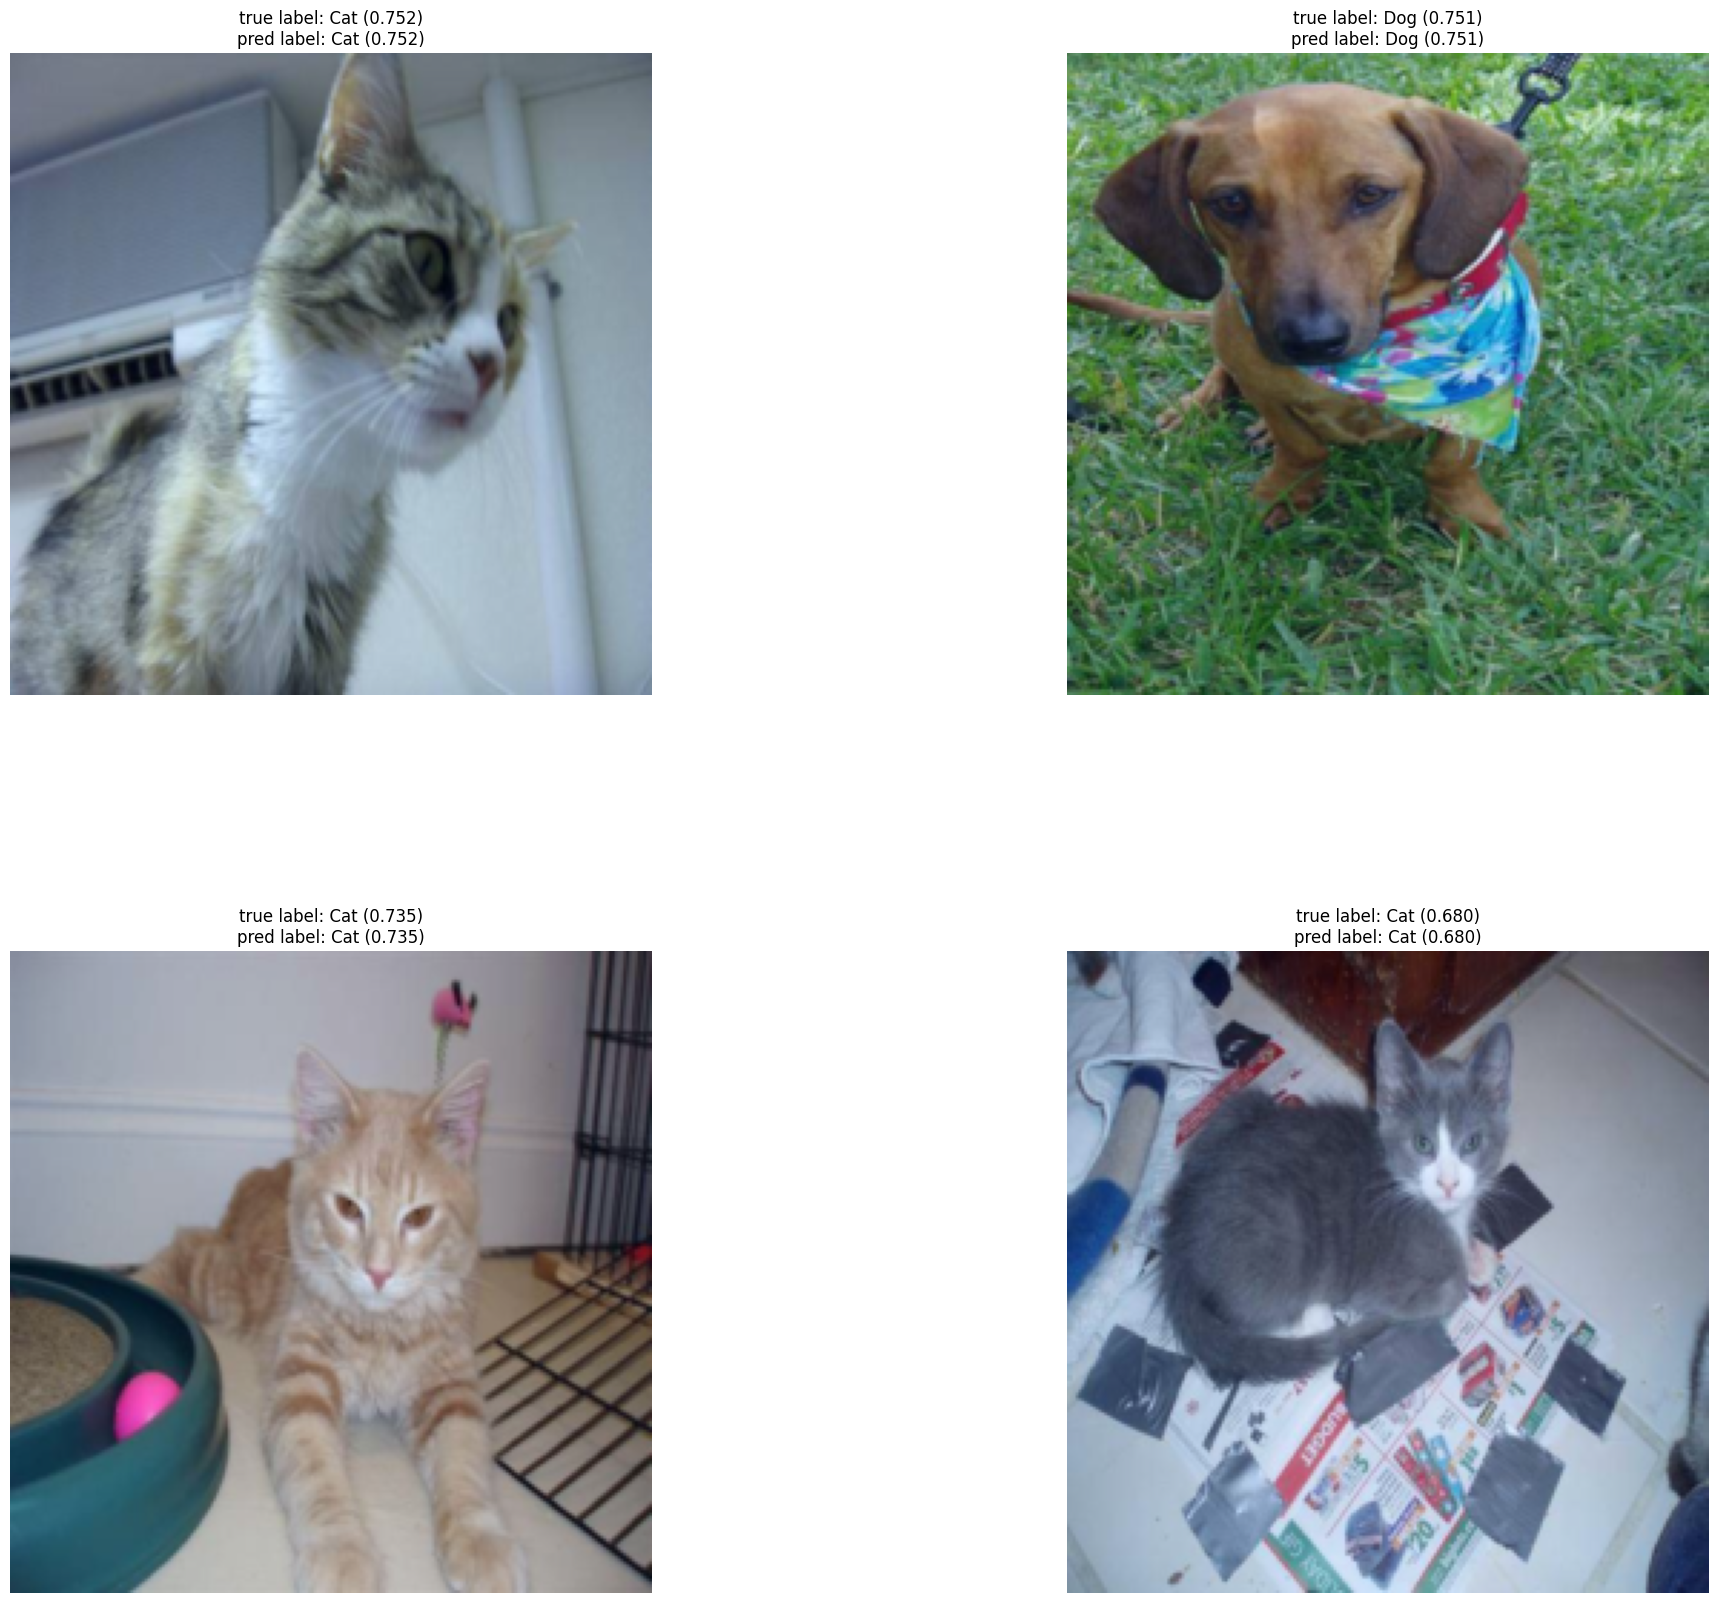

In [28]:
# 6-64 예측 결과 이미지 출력
import matplotlib.pyplot as plt
classes = test_dataset.classes
N_IMAGES = 5
plot_most_correct(correct_examples, classes, N_IMAGES)